## Imports

In [1]:
import matplotlib.pyplot as plt

import numpy as np

from src.models.TurbulenceNetwork import TurbulenceNetworkBayesian
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

%load_ext autoreload
%autoreload 2

%matplotlib inline

## Creating Data

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


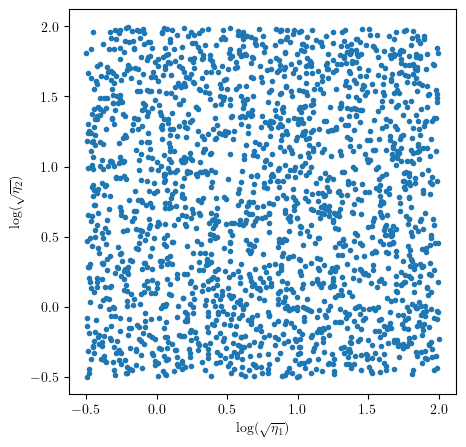

In [2]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.1, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 2000, shuffle=True, gen_type="all")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Defining Data Sets and Scaling

In [3]:
from sklearn.preprocessing import StandardScaler

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_train = x_scaler.transform(etas_train).astype(np.float32)
y_train = y_scaler.transform(gs_train).astype(np.float32)

x_test = x_scaler.transform(etas_test).astype(np.float32)
y_test = y_scaler.transform(gs_test).astype(np.float32)

## Training

In [30]:
trained_gps = []

for i in range(y_train.shape[1]):
    kernel = 1*RBF(length_scale=np.array([1.0, 1.0]), length_scale_bounds=(1e-4, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=7)

    gp.predict()

    gp = gp.fit(x_train, y_train[:, i])
    trained_gps.append(gp)

for gp in trained_gps:
    print(gp.kernel_)
    print(gp.log_marginal_likelihood(gp.kernel_.theta))


#kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-6, 1e2))
#gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
#gp = gp.fit(x_train, y_train)

/home/codygrogan/.local/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/codygrogan/.local/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.443**2 * RBF(length_scale=[0.0725, 0.193])
4727.258084402842
0.528**2 * RBF(length_scale=[0.172, 0.205])
10113.116141094313
0.451**2 * RBF(length_scale=[0.149, 0.216])
9968.762128985512


## Plotting Samples

7.640141270670607e-05


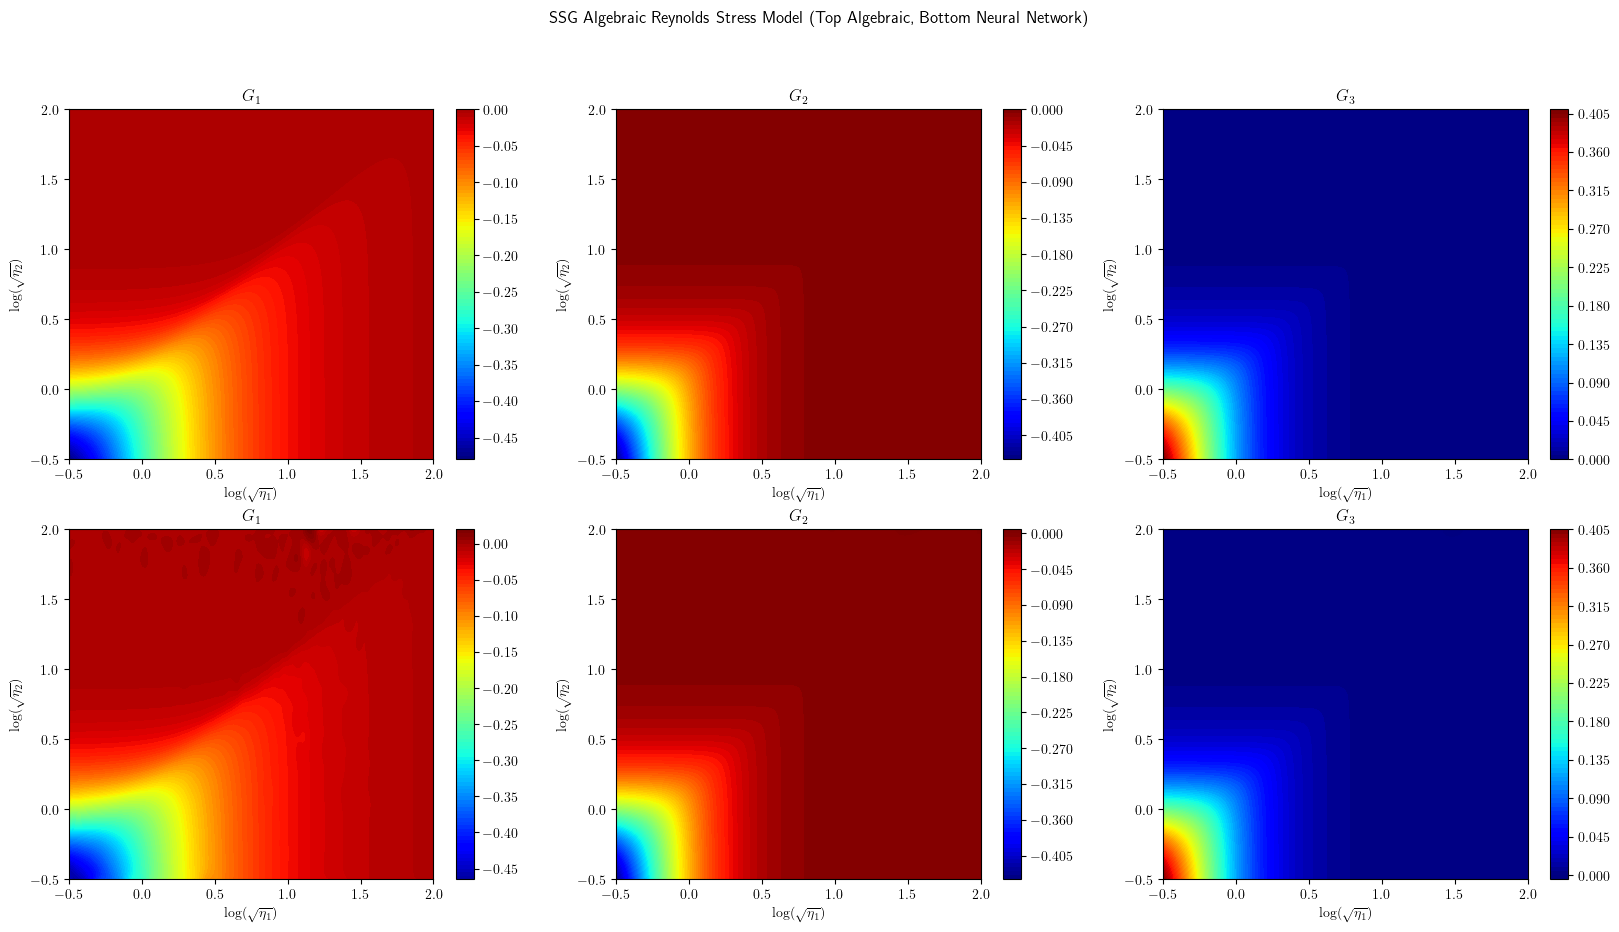

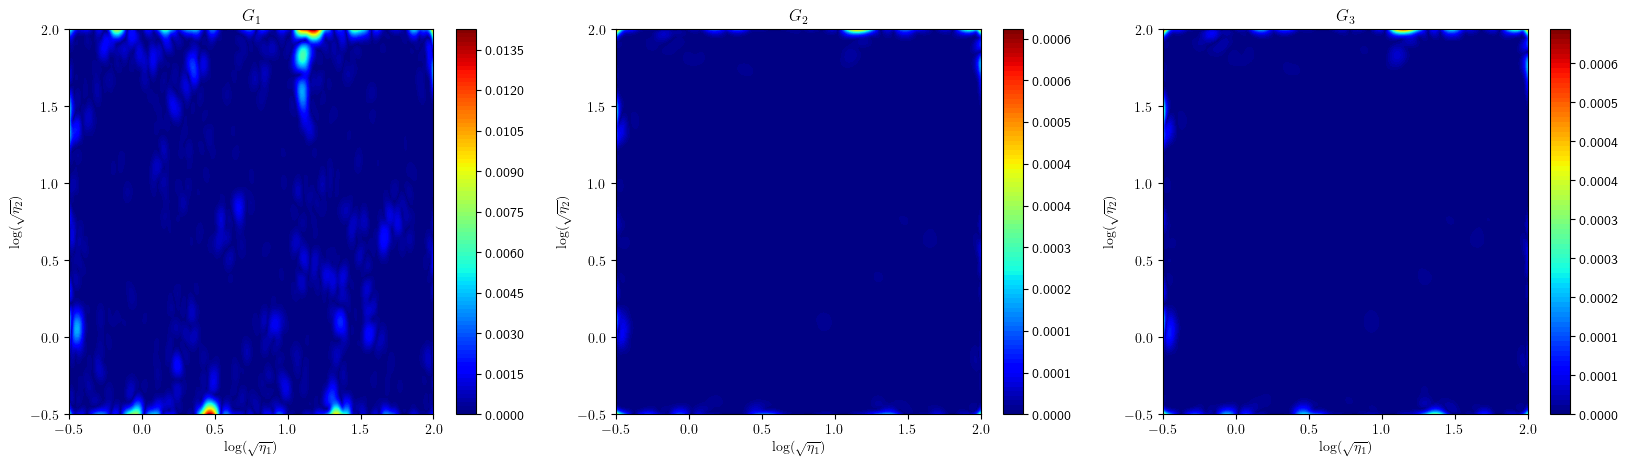

In [31]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

etas = x_scaler.transform(etas)

pred_mean = []
pred_std = []

num_splits = 3

for x_split in np.array_split(etas, num_splits):
    pred_mean_split = np.zeros((x_split.shape[0], len(trained_gps)))
    pred_std_split = np.zeros((x_split.shape[0], len(trained_gps)))

    for i, gp in enumerate(trained_gps):
        pred_mean_split[:, i], pred_std_split[:, i] = gp.predict(x_split, return_std=True)
    
    pred_mean.append(pred_mean_split)
    pred_std.append(pred_std_split)

pred_mean = np.concatenate(pred_mean, axis=0)
pred_std = np.concatenate(pred_std, axis=0)


# y = ln(-G_1)
# E[G_1] = E[-e^y] -e^E[y]

#pred_mean, pred_std = gp.predict(etas, return_std=True)

pred_mean = y_scaler.inverse_transform(pred_mean)
pred_std = pred_std * y_scaler.scale_

print(np.mean(np.abs(target - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), pred_mean.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim))

## Output CHPC Result

### Getting test outputs for each sample

1.1654867227871655e-05


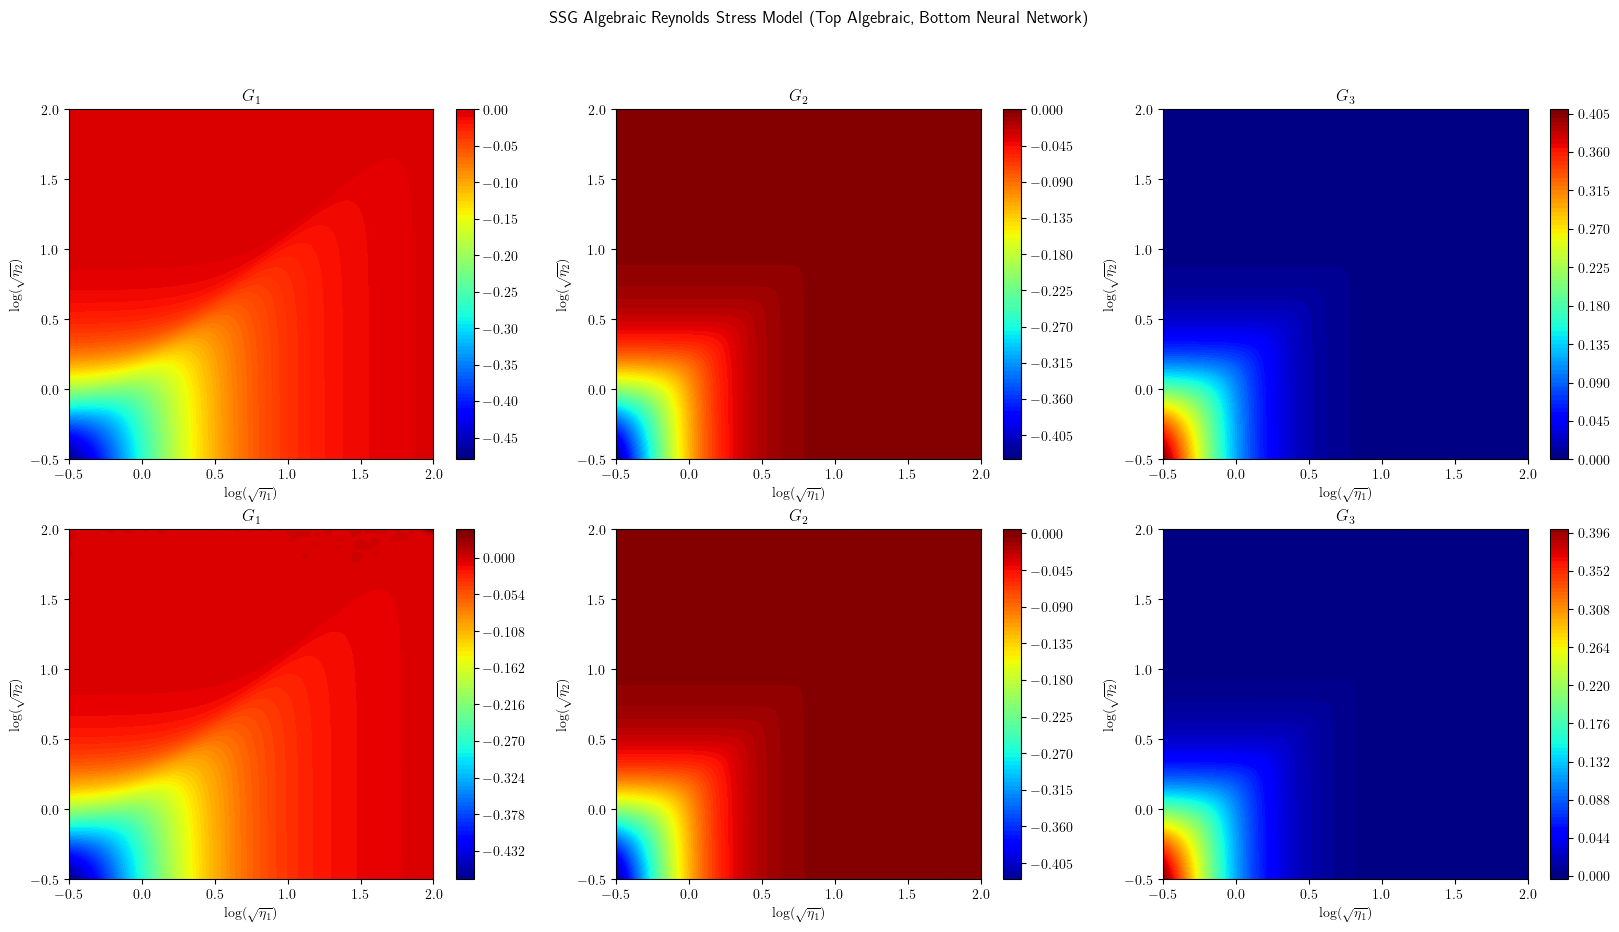

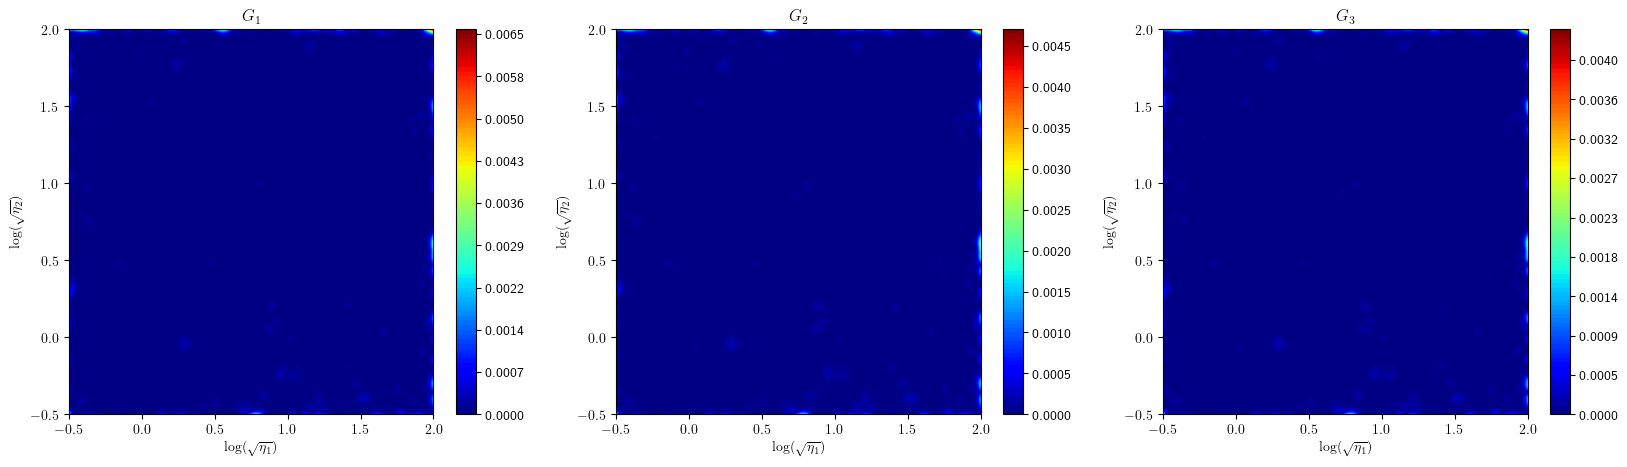

In [4]:
preds = np.load("data/GP/Mean.npy")
stds = np.load("data/GP/Std.npy")

dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)

print(np.mean(np.abs(G_s - preds)))

plot_heat_map_compare(x_grid, y_grid, G_s.T.reshape(3, dim, dim), preds.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, stds.T.reshape(3, dim, dim))